In [1]:
#import required packages
#basics
import pandas as pd 
import numpy as np

#misc
import gc
import time
import warnings
#stats
#from scipy.misc import imread
from scipy import sparse
import scipy.stats as ss
#viz
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
import seaborn as sns
from wordcloud import WordCloud ,STOPWORDS
from PIL import Image
#import c as venn
#nlp
import string
import re    #for regex
import nltk
from nltk.corpus import stopwords
import spacy
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
# Tweet tokenizer does not split at apostophes which is what we want
from nltk.tokenize import TweetTokenizer   
#FeatureEngineering
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
#settings
start_time=time.time()
color = sns.color_palette()
sns.set_style("dark")
eng_stopwords = set(stopwords.words("english"))
warnings.filterwarnings("ignore")
lem = WordNetLemmatizer()
tokenizer=TweetTokenizer()
%matplotlib inline


In [2]:
data = pd.read_csv('Reviews.csv')

In [3]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
data.shape

(568454, 10)

This is our dataset, where we have:

Id:Row Id

ProductId:Unique identifier for the product

UserId:Unqiue identifier for the user

ProfileName:Profile name of the user

HelpfulnessNumerator: Number of users who found the review helpful

HelpfulnessDenominator: Number of users who indicated whether they found the review helpful or not

Score: Rating between 1 and 5

Time: Timestamp for the review

Summary: Brief summary of the review

Text: Text of the review

# ProductId

Let's first check how many identical Product Id is present in the dataset, I think there should be many products which are repeated as a single product will be reviewed by multiple users.

DATA BALANCING

In [5]:
data['ProductId'].nunique()

74258

In [6]:
df_prod=pd.DataFrame(data['ProductId'].value_counts()).reset_index()
df_prod.columns=['Productid','Count']
df_prod.head(10)

,Productid,Count
0,B007JFMH8M,913
1,B002QWHJOU,632
2,B002QWP89S,632
3,B002QWP8H0,632
4,B0026RQTGE,632
5,B003B3OOPA,623
6,B001EO5Q64,567
7,B0026KPDG8,564
8,B001RVFERK,564
9,B006HYLW32,564



Let's see how many product has review more than 50.

In [7]:
df_prod[df_prod['Count']>10].shape[0]

9618

Thus from above we understood that there are 74258 unique product in our dataset and out of that only 9618 products has been reviewed more that 10 times. I will be taking 10 as threshold is future calculation too.

# UserId


In [8]:
data.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [9]:
data['UserId'].nunique(),data.shape[0]

(256059, 568454)


Thus there are only 2.5L users out of 5.68L reviews, which means a user has given more than one review for more than one product.
But first lets check if ther is any duplicate entry. i:e same product id having same review from same user id.

In [10]:
data[data.duplicated(['UserId','ProductId','Time'])]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
426,427,B000G6RYNE,A1Y3XPZK9ZADFW,albinocrow,0,0,4,1334016000,"pretty good, could be better",Glad to find these in a one ounce size but the...
435,436,B000G6RYNE,A15USNEAJUXOSH,L. Schrank,0,0,5,1326067200,Delicious,"I love these chips, I buy the 24 pack once a m..."
467,468,B000G6RYNE,A3PJZ8TU8FDQ1K,Jared Castle,0,0,5,1231718400,"Crunchy, salty, sweet...finally, a Superbowl s...",These Honey Dijon chips bring a terrific balan...
486,487,B000G6RYNE,A31N6KB160O508,Fran W.,0,0,4,1214006400,Firm quality chip,Just got this order and it is ok. A bit light ...
540,541,B000G6RYNE,A3RMGIKUWGPZOK,Jean Visnefski,1,3,3,1245024000,Not the Best,"These chips are okay. Personally, I find the ..."
574,575,B000G6RYNE,A3PJZ8TU8FDQ1K,Jared Castle,2,2,5,1231718400,"One bite and you'll become a ""chippoisseur""","I'm addicted to salty and tangy flavors, so wh..."
587,588,B000G6RYNE,A2OEUROGZDTXUJ,J. Graves,1,1,5,1327968000,My favorite Kettle Chip,"These are my favorite, but they aren't for eve..."
600,601,B000G6RYNE,A3RMGIKUWGPZOK,Jean Visnefski,1,1,5,1245024000,Fantastic,I've eaten other brands of unsalted potato chi...
622,623,B000G6RYNE,ADS5APY1NKTL4,"D. Pawl ""Dani""",5,7,5,1175040000,these potato chips are yummy....,"I try to be good, but when I feel like indulgi..."
901,902,B000ER6YO0,A3NHUQ33CFH3VM,Citizen John,5,5,3,1255651200,Repeated deliveries of broken jars. Great pro...,I liked getting this one for my twin 10-month ...


So let us remove the duplicate entries as a single user can review only a single product at a particular time.

In [11]:
data=data.drop_duplicates(['UserId','ProductId','Time',],keep='first')

In [12]:
data[data.duplicated(['UserId','ProductId','Time'])]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text


In [13]:
data.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [14]:
df_user=pd.DataFrame(data['UserId'].value_counts()).reset_index()
df_user.columns=['UserId','Count']
df_user.head(10)

,UserId,Count
0,A3OXHLG6DIBRW8,422
1,A1YUL9PCJR3JTY,392
2,AY12DBB0U420B,389
3,A281NPSIMI1C2R,365
4,A1Z54EM24Y40LL,251
5,A2MUGFV2TDQ47K,201
6,AQQLWCMRNDFGI,176
7,A1TMAVN4CEM8U8,169
8,AZV26LP92E6WU,167
9,A2SZLNSI5KOQJT,166



So we have quite a good number of users who has given good number of reviews.

# HelpfulnessNumerator and HelpfulnessDenominator


From the defination we can understand that HelpfulnessNumerator should always be lesser than HelpfulnessDenominator. So lets check if we can find any anamoly. If we do then we will drop that data.

Further we will analyze how the helpfulnessnumerator helps in determining the score.

In [15]:
data['HelpfulnessNumerator'].describe()

count    564264.000000
mean          1.742411
std           7.655088
min           0.000000
25%           0.000000
50%           0.000000
75%           2.000000
max         866.000000
Name: HelpfulnessNumerator, dtype: float64

In [16]:
data['HelpfulnessDenominator'].describe()

count    564264.000000
mean          2.224257
std           8.305007
min           0.000000
25%           0.000000
50%           1.000000
75%           2.000000
max         923.000000
Name: HelpfulnessDenominator, dtype: float64

In [17]:
data['HelpfulnessDenominator'].isnull().sum()

0

In [18]:
data['HelpfulnessNumerator'].isnull().sum()

0

In [19]:
    data['HelpfulnessNumerator'].value_counts()

0      301757
1      115624
2       53264
3       28767
4       16878
5       11340
6        7298
7        5339
8        3861
9        3068
10       2431
11       1974
12       1616
13       1184
14       1005
15        829
16        821
17        581
18        566
19        489
20        449
21        369
23        327
22        294
24        293
25        227
29        201
26        194
27        190
31        160
        ...  
152         1
158         1
159         1
162         1
151         1
150         1
169         1
146         1
174         1
145         1
179         1
143         1
188         1
193         1
253         1
199         1
200         1
202         1
133         1
204         1
206         1
207         1
212         1
218         1
223         1
126         1
231         1
233         1
153         1
491         1
Name: HelpfulnessNumerator, Length: 231, dtype: int64

In [20]:
df_help_den=pd.DataFrame(data['HelpfulnessDenominator'].value_counts()).reset_index()
df_help_den.columns=['Helpful_or_not','Count']
df_help_den_20=df_help_den.head(20)
df_help_den_20

,Helpful_or_not,Count
0,0,268411
1,1,111861
2,2,60969
3,3,34114
4,4,22151
5,5,14719
6,6,10270
7,7,7374
8,8,5376
9,9,4359


In [21]:
print('Total number of reviews captured in Denominator is:',df_help_den_20['Count'].sum())

Total number of reviews captured in Denominator is: 556498


In [22]:
df_help=pd.DataFrame(data['HelpfulnessNumerator'].value_counts()).reset_index()
df_help.columns=['Helpfullness','Count']
df_help_20=df_help.head(20)
df_help_20

,Helpfullness,Count
0,0,301757
1,1,115624
2,2,53264
3,3,28767
4,4,16878
5,5,11340
6,6,7298
7,7,5339
8,8,3861
9,9,3068


In [23]:
print('Total number of reviews captured in Numerator is:',df_help_20['Count'].sum())

Total number of reviews captured in Numerator is: 558692


In [24]:
data[data['HelpfulnessNumerator']==866]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
190733,190734,B000FI4O90,A1GQGYROVZVW49,P. Schmidt,866,878,5,1164672000,Works as Advertised - Classy Product,see update at end of review<br /><br />*******...


In [25]:
data.shape

(564264, 10)


Thus from above understood that out of 5.6L reviews of product 2.69L has been provided with no feedback for review reviews. Further 3L reviews has no helpfulness.

Let.s create one new column which will indicate not helpfulness of the review. We will obtain it simply by subtracting denominator with numerator.

In [26]:
data['Not_helpfull']=data['HelpfulnessDenominator']-data['HelpfulnessNumerator']

In [27]:
data['Not_helpfull'].describe()

count    564264.000000
mean          0.481845
std           1.902848
min          -2.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         140.000000
Name: Not_helpfull, dtype: float64

In [28]:
data[data['Not_helpfull']<0]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Not_helpfull
44736,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...,-1
64421,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...,-2


Let's drop this two rows as numerator greater than denominator makes no sense.

In [29]:
data=data.drop([44736,64421])

In [30]:
data['Not_helpfull'].describe()

count    564262.000000
mean          0.481852
std           1.902847
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         140.000000
Name: Not_helpfull, dtype: float64

Let us introduce a new feature upvote% so that we can understand the the helpfull numerator percentage.

# DATA['UPVOTE%']

In [31]:
data['upvote%']=np.where(data['HelpfulnessDenominator']>0,data['HelpfulnessNumerator']/data['HelpfulnessDenominator'],-1)

In [32]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Not_helpfull,upvote%
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,0,1.0
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,0,-1.0
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,0,1.0
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,0,1.0
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,0,-1.0


In [33]:
data['upvote%'].value_counts()

-1.000000    268411
 1.000000    182026
 0.000000     33346
 0.500000     21458
 0.666667     10438
 0.750000      6279
 0.333333      5305
 0.800000      3688
 0.833333      2593
 0.250000      2107
 0.600000      2085
 0.857143      1694
 0.400000      1455
 0.875000      1169
 0.200000      1117
 0.714286      1060
 0.888889       916
 0.900000       810
 0.166667       711
 0.909091       670
 0.777778       615
 0.571429       594
 0.428571       539
 0.625000       529
 0.916667       476
 0.923077       463
 0.285714       446
 0.142857       444
 0.700000       335
 0.555556       323
              ...  
 0.976636         1
 0.205128         1
 0.242424         1
 0.854369         1
 0.465517         1
 0.987342         1
 0.955224         1
 0.152778         1
 0.978313         1
 0.971698         1
 0.941748         1
 0.911392         1
 0.685185         1
 0.189189         1
 0.910256         1
 0.871429         1
 0.962791         1
 0.775701         1
 0.868421         1


In [34]:
data['helpful%']=pd.cut(data['upvote%'],bins=[-1,0,0.2,0.4,0.6,0.8,1.0],labels=['Empty', '0-20%', '20-40%', '40-60%', '60-80%', '80-100%'], include_lowest = True)

In [35]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Not_helpfull,upvote%,helpful%
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,0,1.0,80-100%
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,0,-1.0,Empty
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,0,1.0,80-100%
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,0,1.0,80-100%
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,0,-1.0,Empty


In [36]:
y={'0-20%':'0', '20-40%':'0', '40-60%':'0', '60-80%':'1', '80-100%':'1'}
data=data[data['helpful%']!='Empty']
data['helpful%']=data['helpful%'].map(y)

In [37]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Not_helpfull,upvote%,helpful%
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,0,1.0,1
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,0,1.0,1
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,0,1.0,1
8,9,B000E7L2R4,A1MZYO9TZK0BBI,R. James,1,1,5,1322006400,Yay Barley,Right now I'm mostly just sprouting this so my...,0,1.0,1
10,11,B0001PB9FE,A3HDKO7OW0QNK4,Canadian Fan,1,1,5,1107820800,The Best Hot Sauce in the World,I don't know if it's the cactus or the tequila...,0,1.0,1


# SCORE

In [38]:
data['Score'].describe()

count    262505.000000
mean          4.076783
std           1.413292
min           1.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: Score, dtype: float64

In [39]:
data['Score'].isnull().sum()

0


Thus maximum score is 5 and minimum is 1. Mean is 4.18 that means most of the score is on the higher side.No score is null.

In [40]:
data.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text',
       'Not_helpfull', 'upvote%', 'helpful%'],
      dtype='object')

In [41]:
df_score=data[['HelpfulnessNumerator','HelpfulnessDenominator','Not_helpfull','Score','helpful%']]

In [42]:
df_score.head()

,HelpfulnessNumerator,HelpfulnessDenominator,Not_helpfull,Score,helpful%
0,1,1,0,5,1
2,1,1,0,4,1
3,3,3,0,2,1
8,1,1,0,5,1
10,1,1,0,5,1


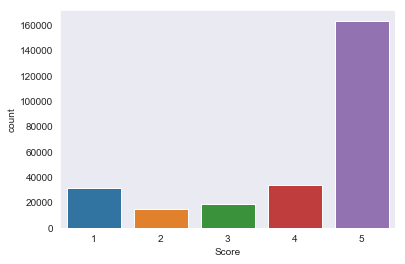

In [43]:
sns.countplot(df_score['Score'])

In [44]:
Score_helpnum=pd.DataFrame(df_score.groupby('Score')['HelpfulnessNumerator'].sum()).reset_index()
Score_helpnum.columns=['Score','Count']
Score_helpnum

,Score,Count
0,1,140382
1,2,55169
2,3,72118
3,4,111332
4,5,604173


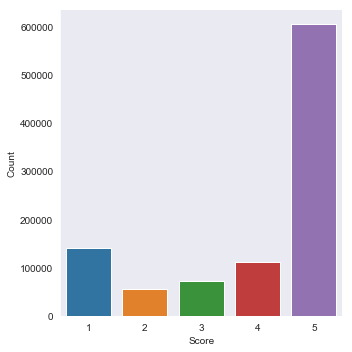

In [45]:
sns.catplot(x='Score',y='Count',data=Score_helpnum,kind='bar')

In [46]:
Score_helpden=pd.DataFrame(df_score.groupby('Score')['HelpfulnessDenominator'].sum()).reset_index()
Score_helpden.columns=['Score','Count']
Score_helpden

,Score,Count
0,1,227787
1,2,83199
2,3,95664
3,4,126446
4,5,659898


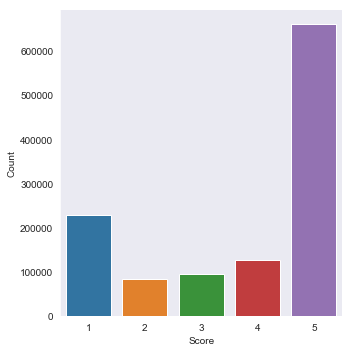

In [47]:
sns.catplot(x='Score',y='Count',data=Score_helpden,kind='bar')

In [48]:
Score_nothelp=pd.DataFrame(df_score.groupby('Score')['Not_helpfull'].sum()).reset_index()
Score_nothelp.columns=['Score','Count']
Score_nothelp

,Score,Count
0,1,87405
1,2,28030
2,3,23546
3,4,15114
4,5,55725


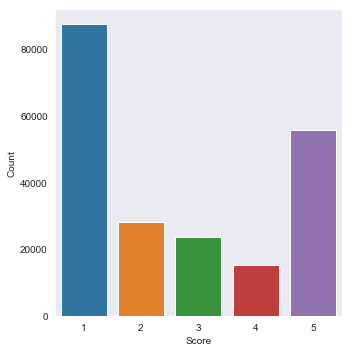

In [49]:
sns.catplot(x='Score',y='Count',data=Score_nothelp,kind='bar')

Thus from review useful and not useful plot what we understood that if a review is useful for other customer generally they go on to buy the food item and thus scoring it 5. Many products for which review has not been found helpful has low score as customer has not bought that product may be they doybted the product.

In [50]:
data.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text',
       'Not_helpfull', 'upvote%', 'helpful%'],
      dtype='object')


Lets check what is the score recieved by a product if it has high helpfulness.

In [51]:
data[['ProductId','HelpfulnessNumerator','HelpfulnessDenominator','Score']].sort_values(by='HelpfulnessNumerator',ascending=False).head(10)

,ProductId,HelpfulnessNumerator,HelpfulnessDenominator,Score
190733,B000FI4O90,866,878,5
207712,B00012182G,844,923,3
566779,B001PQTYN2,808,815,5
235722,B001F10XUU,580,593,1
293135,B008VQ01Y0,559,562,5
130478,B005F3IAPE,559,562,5
385450,B0051SU0OW,559,562,5
297366,B0069GOKGE,559,562,5
116802,B008F2K1YU,559,562,5
467800,B0065G59F4,559,562,5


o from above what we see high review helpfulness means high score. Only 2 product are saying otherwise.

In [52]:
data[['ProductId','HelpfulnessNumerator','HelpfulnessDenominator','Score']].sort_values(by='HelpfulnessNumerator',ascending=True).head(10)

,ProductId,HelpfulnessNumerator,HelpfulnessDenominator,Score
0,B001E4KFG0,1,1,5
305639,B001ELL4E0,1,1,5
305640,B001ELL4E0,1,1,4
305641,B001ELL4E0,1,1,3
305642,B001ELL4E0,1,1,5
305661,B001ELL4E0,1,5,1
305663,B001ELL4E0,1,8,1
305665,B004GEX0X0,1,1,5
305666,B00474GBNU,1,1,5
305673,B0001PB0LC,1,3,2



But from above what we can see that low review feedback doesn't mean low score.

In [53]:
data.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text',
       'Not_helpfull', 'upvote%', 'helpful%'],
      dtype='object')

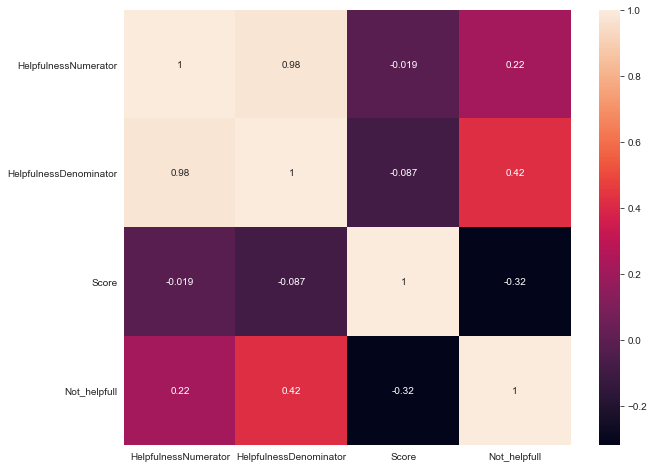

In [54]:
temp_df=data[['HelpfulnessNumerator','HelpfulnessDenominator','Score','Not_helpfull']]
# filter temp by removing clean comments
# temp_df=temp_df[~train.clean]

corr=temp_df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True)

From the correlation matrix also we can see HelpfulnessDenominator and HelpfulnessNumerator are not that strongly related. But can find a strong -ve corelation between Score and Not_helpfull feature.

# TEXT

This text will be directly related to the score as  high score product will have positive reviews while the low score product will have -ve reviews.

1) will be checking the word clould based on the score , to understand what are the most prominent words used against each section.

2)We will be doing out feature engineering based on below categories:
    
    ##Direct features

    Features which are a directly due to words/content.We would be exploring the following techniques
    
    Word frequency features
    
    Count features
    
    Bigrams
    
    Trigrams
    
    Vector distance mapping of words (Eg: Word2Vec)
    
    Sentiment scores

3)Indirect features:

    count of sentences:
    
    count of words
    
    count of unique words
    
    count of letters
    
    count of punctuations
    
    count of uppercase words/letters
    
    count of stop words
    
    Avg length of each word
    
    Number of capitals :Dissatisfied customer can write in CAPS to express dissatisfaction.
    
    Number of exclamation marks 
    
    Number of question marks 
    
    Number of symbols
    
    Number of (happy) smilies :- Satisfied customer will use happy smilies.
    
    Length of the comment - my initial assumption is that angry people write short messages
    

# WORDCLOUD

In [55]:
data.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text',
       'Not_helpfull', 'upvote%', 'helpful%'],
      dtype='object')

In [56]:
data["Text"]=data["Text"].apply(lambda x:x.replace('<br />',""))

In [57]:
d=data[data['HelpfulnessDenominator']>10]==5
d[d['Score']==4]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Not_helpfull,upvote%,helpful%


In [58]:
data.shape

(262505, 13)

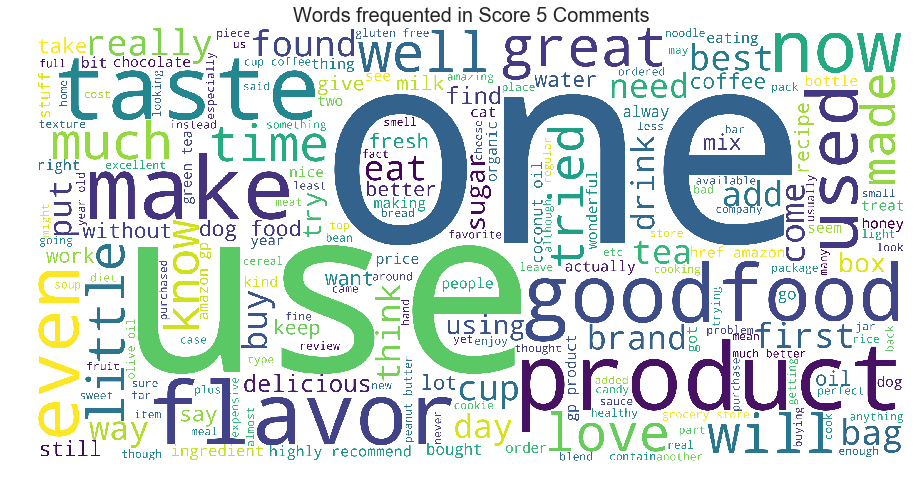

In [59]:
d=data[data['HelpfulnessDenominator']>10]
subset=d[d['Score']==5]
Score5_corpus=' '.join(subset.Text.values)
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=2000, width=4000).generate(Score5_corpus)
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.title("Words frequented in Score 5 Comments", fontsize=20)
plt.axis('off')
plt.show()

"Highly recommend" ,gluten free are few words which customer thinks useful while buying , thus this have high scores too.

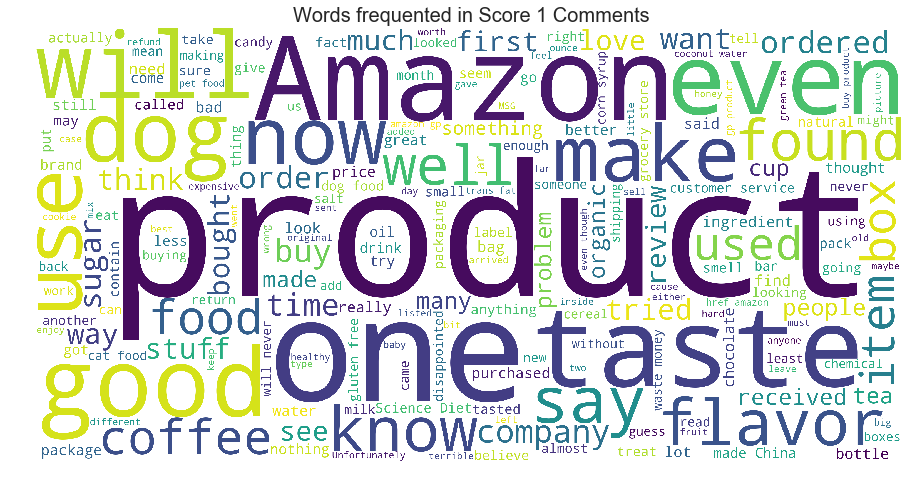

In [115]:
d=data[data['HelpfulnessDenominator']>10]
subset=d[d['Score']==1]
Score1_corpus=' '.join(subset.Text.values)
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=2000, width=4000).generate(Score1_corpus)
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.title("Words frequented in Score 1 Comments", fontsize=20)
plt.axis('off')
plt.show()

In [61]:
subset

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Not_helpfull,upvote%,helpful%
12190,12191,B00141UC9I,A88WK54WGJ15T,Oregon CATS,149,155,1,1235088000,"Good idea , but....made in China","Originally, these were made in US. Now made in...",6,0.961290,1
32377,32378,B001AJ1ULS,A88WK54WGJ15T,Oregon CATS,149,155,1,1235088000,"Good idea , but....made in China","Originally, these were made in US. Now made in...",6,0.961290,1
34300,34301,B001P3NU30,A37GFKV81AL1VF,D. Miyao,112,120,1,1261440000,Be careful. May be good for teeth but present...,I have a 1 year old lab/Shepard mix and she is...,8,0.933333,1
47937,47938,B004SRH2B6,A1WX42M589VAMQ,Mir,110,124,1,1274054400,Bummer: My fave packaged coconut water is RUINED!,Note: Please carefully review the NEGATIVE rev...,14,0.887097,1
55919,55920,B003EX2ECM,AFKP2U4TJJE0R,mtg,15,108,1,1302220800,dont buy noooooooooooooo bad for health never ...,meat glue is used daily in meat and is very da...,93,0.138889,0
69239,69240,B0018KR8V0,A1V1LLQUE8A2NR,Pen Pal,39,151,1,1159401600,"""Health"" Does Not Always Equal Health",It took me a decade of yo-yo dieting on variou...,112,0.258278,0
86219,86220,B000084E6V,A1PUM736GQ441P,"Devin Dupree ""ddupree44""",200,215,1,1223510400,DO NOT BUY- WARNING!!!!,My wife & I religiously bought dental dinos fo...,15,0.930233,1
98614,98615,B004GW6O9E,A1V1LLQUE8A2NR,Pen Pal,39,151,1,1159401600,"""Health"" Does Not Always Equal Health",It took me a decade of yo-yo dieting on variou...,112,0.258278,0
103959,103960,B00065LI0A,A2WJ1V4LK1578Q,Paul E. Seidel,97,103,1,1278979200,Wouldn't Send to Anyone,Received this for Fathers Day and found the ba...,6,0.941748,1
120394,120395,B005K4Q37A,AKGG1DDHNA7XW,Bud,113,127,1,1327363200,Ingredients,Ingredient: Partially Hydrogenated Vegetable O...,14,0.889764,1



"Waste money","disappointed","tried" are kind of word which can be related to bad review , hence bad score. 

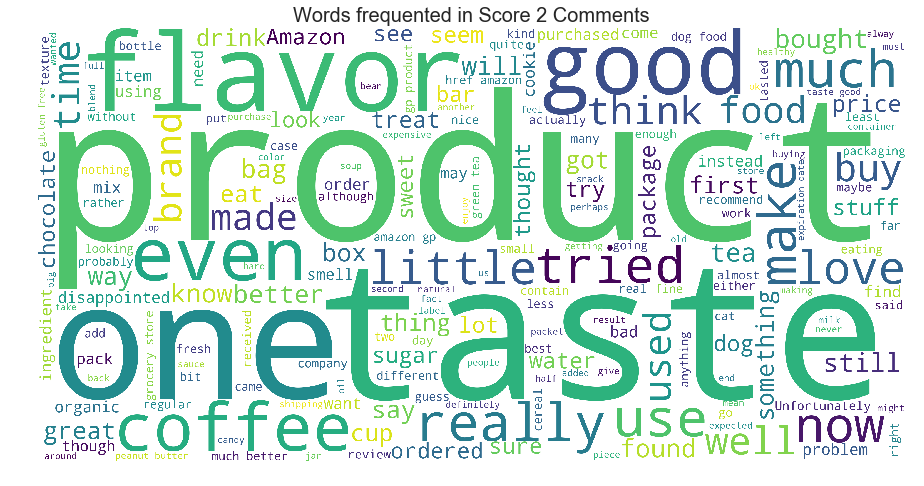

In [62]:
subset=data[data.Score==2]
Score2_corpus=' '.join(subset.Text.values)
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=2000, width=4000).generate(Score2_corpus)
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.title("Words frequented in Score 2 Comments", fontsize=20)
plt.axis('off')
plt.show()

Not much of useful information..Lets proceed further with indirect features.

#New Feature Extraction****

In [63]:
data['cnt_Sent']=data["Text"].apply(lambda x: len(re.findall('\n',str(x)))+1)

In [64]:
data['cnt_words']=data["Text"].apply(lambda x: len(str(x).split()))

In [65]:
data['unq_words']=data["Text"].apply(lambda x: len(set(str(x).split())))

In [66]:
data['cnt_lett']=data["Text"].apply(lambda x: len(str(x)))

In [67]:
data['cnt_punc']=data["Text"].apply(lambda x: len([c for c in str(x) if c in string.punctuation])) 

In [68]:
data['cnt_wrd_upper']=data["Text"].apply(lambda x: len([c for c in str(x).split() if c.isupper()])) 

In [69]:
data['cnt_wrd_title']=data["Text"].apply(lambda x: len([c for c in str(x).split() if c.istitle()])) 

In [70]:
data['cnt_stopwords']=data["Text"].apply(lambda x: len([c for c in str(x).lower().split() if c in STOPWORDS])) 

In [71]:
data['mean_word_len']=data["Text"].apply(lambda x:np.mean([len(w) for w in str(x).split()])) 

In [72]:
data['Text'][0]

'I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.'

In [73]:
data['no.of_exclaim']=data["Text"].apply(lambda x:len([c for c in str(x).split() if c in "!"]))

In [74]:
data[data['no.of_exclaim']!=0]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,...,cnt_Sent,cnt_words,unq_words,cnt_lett,cnt_punc,cnt_wrd_upper,cnt_wrd_title,cnt_stopwords,mean_word_len,no.of_exclaim
408,409,B001IZM8A6,AVI998S4IX2Y1,"Melissa N. Connor ""rare maven""",1,1,5,1257897600,A Fantastic & Healthy Product,A grande item ! Delicious fish with the ultim...,...,1,42,36,214,5,2,5,20,4.047619,3
577,578,B000G6RYNE,A1Q7A78VSQ5GQ4,"Nice Lady ""a reasonable person""",4,5,5,1249344000,"YUM! If you want a snack, have something REALL...",I've found a new taste treat. I'm not a big on...,...,1,115,91,638,32,4,11,47,4.521739,1
988,989,B006F2NYI2,A36WE3X9G0DZUZ,Gale P,2,2,5,1324339200,love this hot sauce,I was never much of a hot sauce fan until I ta...,...,1,90,65,465,15,6,15,45,4.177778,1
1237,1238,B002G8N4ZW,A20S7XV2JK0UXL,Gregory C. Ward,1,1,4,1343260800,Spray garlic!,It's a great product- especially if you like g...,...,1,49,44,259,17,1,5,20,4.306122,1
1501,1502,B002KGN4LE,A253U7UEJQCVJI,"Johanna Castano ""JC""",1,1,5,1285286400,Best Organic milk out there..my baby switched ...,Our 9 month old originally was spitting up a l...,...,1,265,172,1413,51,12,37,127,4.305660,4
1999,2000,B001E5E29A,AZ9N3928BGQ0E,"J. Nachison ""long-time SF and history lover""",7,8,5,1206835200,"waffles, schmaffles !!","What can i say?? They are wonderful, and the ...",...,1,25,24,133,9,0,2,11,4.200000,1
2501,2502,B0004MZVIA,A3ACTJ8H3RSW7C,"Mary Shelly ""1951 VooDoo""",1,1,5,1338681600,Diet Peach Snapple Delivered Safely & Quickly,I ordered this product to send to my friend's ...,...,1,82,64,411,8,2,17,44,4.012195,2
2804,2805,B000J2DQ46,A20IYCN35Z1DKM,leon,1,4,5,1297728000,bar harbor clam chowder,bar harbor clam chowder is an excellent produc...,...,1,29,28,162,4,0,0,10,4.620690,1
4661,4662,B000FBM4FI,A1QF54LKDRD2HV,M. G. Michaels,1,1,5,1260230400,"crispy, versatile, delicious....",I enjoy my Kavli Crispy Thins so much and so o...,...,1,127,95,684,33,4,25,48,4.385827,1
4801,4802,B00139TT72,A3CU3YMUNKV0BO,"M. Rade ""ocean""",2,2,5,1298764800,THE BEST,My cocker puppy 4 mos threw up castor and poul...,...,1,48,44,249,4,1,2,22,4.208333,1


In [75]:
data['no.of_question']=data["Text"].apply(lambda x:len([c for c in str(x).split() if c in "?"]))

In [76]:
data['no.of_question']=data["Text"].apply(lambda x:len([c for c in str(x).split() if c in "?"]))

In [77]:
data['no.of_symb']=data["Text"].apply(lambda x:sum(x.count(w)for w in '*$&#%@'))

In [78]:
data['no.of_happy_smilies']=data["Text"].apply(lambda x:len([c for c in str(x).split() if c in (':-)', ':)', ';-)', ';)')]))

In [79]:
#derived features
#Word count percent in each comment:
data['word_unique_percent']=data['unq_words']*100/data['cnt_words']
#derived features
#Punct percent in each comment:
data['punct_percent']=data['cnt_punc']*100/data['cnt_words']

In [80]:
data.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text',
       'Not_helpfull', 'upvote%', 'helpful%', 'cnt_Sent', 'cnt_words',
       'unq_words', 'cnt_lett', 'cnt_punc', 'cnt_wrd_upper', 'cnt_wrd_title',
       'cnt_stopwords', 'mean_word_len', 'no.of_exclaim', 'no.of_question',
       'no.of_symb', 'no.of_happy_smilies', 'word_unique_percent',
       'punct_percent'],
      dtype='object')

Let us check the correlation matrix of all the features we just created with the Score. We can understnad how useful this features really are

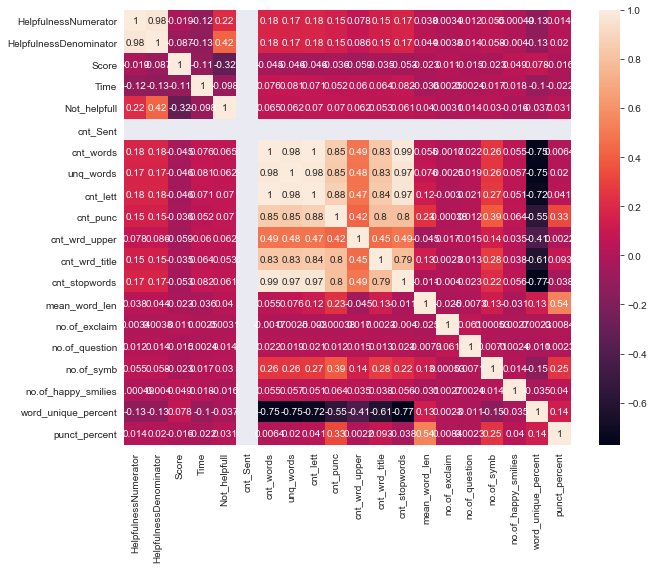

In [81]:
temp_df=data[['HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text',
       'Not_helpfull', 'cnt_Sent', 'cnt_words', 'unq_words', 'cnt_lett',
       'cnt_punc', 'cnt_wrd_upper', 'cnt_wrd_title', 'cnt_stopwords',
       'mean_word_len', 'no.of_exclaim', 'no.of_question', 'no.of_symb',
       'no.of_happy_smilies','word_unique_percent', 'punct_percent']]
# filter temp by removing clean comments
# temp_df=temp_df[~train.clean]

corr=temp_df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True)

In [82]:
print("Find most important features relative to target")
corr =temp_df.corr()
corr.sort_values(["Score"], ascending = False, inplace = True)
corr
print(corr['Score'])

Find most important features relative to target
Score                     1.000000
word_unique_percent       0.078446
no.of_happy_smilies       0.048840
no.of_exclaim             0.011383
no.of_question           -0.014667
punct_percent            -0.016025
HelpfulnessNumerator     -0.018554
mean_word_len            -0.022779
no.of_symb               -0.022821
cnt_wrd_title            -0.035050
cnt_punc                 -0.035754
cnt_words                -0.044524
unq_words                -0.045607
cnt_lett                 -0.045959
cnt_stopwords            -0.052771
cnt_wrd_upper            -0.059261
HelpfulnessDenominator   -0.086808
Time                     -0.111069
Not_helpfull             -0.318787
cnt_Sent                       NaN
Name: Score, dtype: float64


In [83]:
temp_df['cnt_Sent'].value_counts()

1    262505
Name: cnt_Sent, dtype: int64

Most of the features has corelation less than 0.05 other than word_uniqur percent and Not_helpful , have low significance. Let's move forward and convert words to token and then we will obtain the vectorizer using TF-IDF or count vecotorizer.

In [84]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [85]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

DATA BALANCING

In [86]:
data=data[data['Score']!=3]
data['Score_type']=data['Score'].apply(lambda x:'positive' if x>3 else 'negative')

In [87]:
data['Score_type'].value_counts()

positive    197100
negative     46415
Name: Score_type, dtype: int64

In [88]:
data_sampled_pos=data[data['Score_type']=='positive'].sample(n=46415)

In [89]:
data_sampled_neg=data[data['Score_type']=='negative'].sample(n=46415)

In [90]:
data_sample=pd.concat([data_sampled_pos,data_sampled_neg],ignore_index=True)

In [91]:
data_sample['Score_type'].value_counts()

positive    46415
negative    46415
Name: Score_type, dtype: int64

In [92]:
data_sample.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text',
       'Not_helpfull', 'upvote%', 'helpful%', 'cnt_Sent', 'cnt_words',
       'unq_words', 'cnt_lett', 'cnt_punc', 'cnt_wrd_upper', 'cnt_wrd_title',
       'cnt_stopwords', 'mean_word_len', 'no.of_exclaim', 'no.of_question',
       'no.of_symb', 'no.of_happy_smilies', 'word_unique_percent',
       'punct_percent', 'Score_type'],
      dtype='object')

In [93]:
from bs4 import BeautifulSoup
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(data_sample['Text'].values):
    # remove urls from text python
    sentance = re.sub(r"http\S+", "", sentance)
    #python-beautifulsoup-how-to-remove-all-tags-from-an-element
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    #remove words with numbers python
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    #remove spacial character
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    
    #sentance=[lem.lemmatize(word, "v") for word in sentance]
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 92830/92830 [00:32<00:00, 2847.49it/s]


In [94]:
preprocessed_reviews=[lem.lemmatize(word, "v") for word in preprocessed_reviews]

In [95]:
preprocessed_reviews

['given six months cakes christmas year gotten two good opened first afraid not going like much pumpkin cake lovely dense moist yummy cakes travel well keep nicely not filled artificial ingredients first choice would six months wedding cakes light impracticality cakes surprisingly good',
 'far favorite gluten free oats tried prefer bob red mill one smaller brand currently market prefer due fact bit sweeter thinner cut others really like quaker oatmeal grew like quaker oats need certified gluten free oats best substitution love able make oatmeal cookies',
 'like regular special k little bland stuff great eat never get bored got enough blueberry give life not powering',
 'pet guardians please take time educate goes pet food initiative give gift longer healthier life eliminate many chronic health issues pets face save money vet bills long run list benefits goes done extensive research canine feline nutrition highly recommend going feed commercial food welless california naturals innova gr

In [96]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:20])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaaarrrrrggghhh', 'aaaaaahhhhh', 'aaaaaahhhhhyaaaaaa', 'aaaaallll', 'aaaahhhhhh', 'aaaand', 'aaah', 'aachen', 'aacurate', 'aad', 'aadults', 'aaf', 'aafco', 'aah', 'aahing', 'aahs']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (92830, 56530)
the number of unique words  56530


In [97]:
print("some feature names ", count_vect.get_feature_names()[:1000])


some feature names  ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaaarrrrrggghhh', 'aaaaaahhhhh', 'aaaaaahhhhhyaaaaaa', 'aaaaallll', 'aaaahhhhhh', 'aaaand', 'aaah', 'aachen', 'aacurate', 'aad', 'aadults', 'aaf', 'aafco', 'aah', 'aahing', 'aahs', 'aamzon', 'aap', 'aardvark', 'aarp', 'aarrgghhhh', 'aarrgh', 'aarthur', 'aasanfood', 'aauces', 'ab', 'aback', 'abalone', 'abandon', 'abandoned', 'abandoning', 'abandonment', 'abated', 'abates', 'abattoir', 'abbazabba', 'abbey', 'abbott', 'abbreviation', 'abby', 'abbypomeroy', 'abc', 'abd', 'abdomen', 'abdominal', 'abe', 'abeja', 'abejas', 'abel', 'aber', 'aberdeen', 'aberrant', 'aberration', 'aberrations', 'abetter', 'abhor', 'abhorrent', 'abhors', 'abide', 'abietate', 'abilities', 'ability', 'abit', 'abita', 'abject', 'abjectly', 'ablation', 'ablaze', 'able', 'abletate', 'ableto', 'ablution', 'abnormal', 'abnormalities', 'abnormalitywith', 'abnormally', 'abnormalties', 'aboard', 'abode', 'abolitionists', 'abominable', 'abominably', 'abomination', 'abomi

# Bi-Grams and n-Grams.

In [98]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (92830, 5000)
the number of unique words including both unigrams and bigrams  5000


In [99]:
count_vect.get_feature_names()[:10]

['ability',
 'able',
 'able find',
 'able get',
 'absolute',
 'absolutely',
 'absolutely delicious',
 'absolutely love',
 'absolutely loves',
 'absolutely no']

# TF-IDF

In [100]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['aa', 'aafco', 'aback', 'abandon', 'abandoned', 'abc', 'abdomen', 'abdominal', 'abdominal cramping', 'abdominal pain']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (92830, 72090)
the number of unique words including both unigrams and bigrams  72090


In [101]:
#data_y = result['Class']
# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, X_test, y_train, y_test = train_test_split(final_tf_idf,data_sample['Score_type'],stratify=data_sample['Score_type'],test_size=0.20)
# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
#X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train,stratify=y_train,test_size=0.20)

In [102]:
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
import seaborn as sb
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
import gensim
from gensim.models import Word2Vec, KeyedVectors
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from collections import Counter
from sklearn.metrics import accuracy_score

Applying Multinomial Naïve Bayes learning method

In [103]:
prediction = dict()

In [104]:
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB().fit(X_train, y_train)
prediction['Multinomial'] = model.predict(X_test)
training_accuracy = model.score(X_train, y_train)
training_error = 1 - training_accuracy
test_accuracy = accuracy_score(y_test, prediction['Multinomial'] )
test_error = 1 - test_accuracy

print("_" * 101)
print("Training Accuracy: ", training_accuracy)
print("Train Error: ", training_error)
print("Test Accuracy: ", test_accuracy)
print("Test Error: ", test_error)
print("_" * 101)

_____________________________________________________________________________________________________
Training Accuracy:  0.9274345577938167
Train Error:  0.07256544220618333
Test Accuracy:  0.9055262307443714
Test Error:  0.09447376925562856
_____________________________________________________________________________________________________


In [105]:
print("_" * 101)
print("Classification Report: \n")
print(classification_report(y_test, prediction['Multinomial'] ))
print("_" * 101)

_____________________________________________________________________________________________________
Classification Report: 

              precision    recall  f1-score   support

    negative       0.93      0.88      0.90      9283
    positive       0.89      0.93      0.91      9283

    accuracy                           0.91     18566
   macro avg       0.91      0.91      0.91     18566
weighted avg       0.91      0.91      0.91     18566

_____________________________________________________________________________________________________


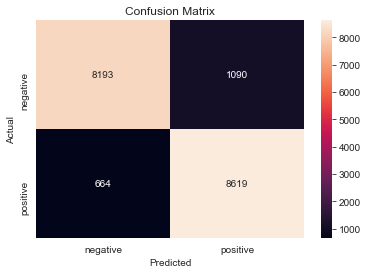

_____________________________________________________________________________________________________


In [106]:
conf_matrix = confusion_matrix(y_test, prediction['Multinomial'])
class_label = ['negative', 'positive']
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
print("_" * 101)

Applying Bernoulli Naïve Bayes learning method

In [107]:
from sklearn.naive_bayes import BernoulliNB
model = BernoulliNB().fit(X_train, y_train)
prediction['Bernoulli'] = model.predict(X_test)
training_accuracy = model.score(X_train, y_train)
training_error = 1 - training_accuracy
test_accuracy = accuracy_score(y_test, prediction['Bernoulli'] )
test_error = 1 - test_accuracy

print("_" * 101)
print("Training Accuracy: ", training_accuracy)
print("Train Error: ", training_error)
print("Test Accuracy: ", test_accuracy)
print("Test Error: ", test_error)
print("_" * 101)


_____________________________________________________________________________________________________
Training Accuracy:  0.8903641064311106
Train Error:  0.10963589356888936
Test Accuracy:  0.8696542066142411
Test Error:  0.1303457933857589
_____________________________________________________________________________________________________


In [108]:
print("_" * 101)
print("Classification Report: \n")
print(classification_report(y_test, prediction['Bernoulli'] ))
print("_" * 101)

_____________________________________________________________________________________________________
Classification Report: 

              precision    recall  f1-score   support

    negative       0.94      0.79      0.86      9283
    positive       0.82      0.95      0.88      9283

    accuracy                           0.87     18566
   macro avg       0.88      0.87      0.87     18566
weighted avg       0.88      0.87      0.87     18566

_____________________________________________________________________________________________________


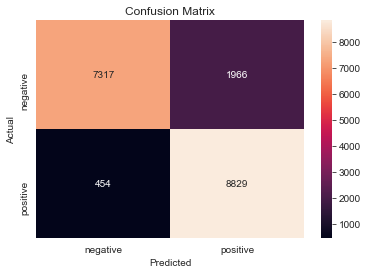

_____________________________________________________________________________________________________


In [109]:
conf_matrix = confusion_matrix(y_test, prediction['Bernoulli'])
class_label = ['negative', 'positive']
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
print("_" * 101)

Applying Logistic regression learning method

In [110]:
from sklearn import linear_model
logreg = linear_model.LogisticRegression(C=1e5)
logreg.fit(X_train, y_train)
prediction['Logistic'] = logreg.predict(X_test)

training_accuracy = model.score(X_train, y_train)
training_error = 1 - training_accuracy
test_accuracy = accuracy_score(y_test, prediction['Logistic'] )
test_error = 1 - test_accuracy

print("_" * 101)
print("Training Accuracy: ", training_accuracy)
print("Train Error: ", training_error)
print("Test Accuracy: ", test_accuracy)
print("Test Error: ", test_error)
print("_" * 101)

_____________________________________________________________________________________________________
Training Accuracy:  0.8903641064311106
Train Error:  0.10963589356888936
Test Accuracy:  0.9182376386943876
Test Error:  0.08176236130561243
_____________________________________________________________________________________________________


In [111]:
print("_" * 101)
print("Classification Report: \n")
print(classification_report(y_test, prediction['Logistic'] ))
print("_" * 101)

_____________________________________________________________________________________________________
Classification Report: 

              precision    recall  f1-score   support

    negative       0.92      0.92      0.92      9283
    positive       0.92      0.92      0.92      9283

    accuracy                           0.92     18566
   macro avg       0.92      0.92      0.92     18566
weighted avg       0.92      0.92      0.92     18566

_____________________________________________________________________________________________________


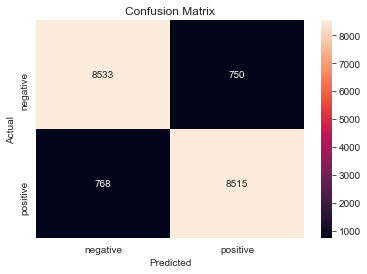

_____________________________________________________________________________________________________


In [112]:
conf_matrix = confusion_matrix(y_test, prediction['Logistic'])
class_label = ['negative', 'positive']
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
print("_" * 101)

In [113]:
prediction

{'Multinomial': array(['positive', 'positive', 'positive', ..., 'negative', 'positive',
        'positive'], dtype='<U8'),
 'Bernoulli': array(['positive', 'positive', 'positive', ..., 'positive', 'positive',
        'positive'], dtype='<U8'),
 'Logistic': array(['positive', 'positive', 'positive', ..., 'negative', 'positive',
        'positive'], dtype=object)}

Applying Xgboost learning method

In [114]:
from sklearn import linear_model
model1= XGBClassifier(C=1e5)
model1.fit(X_train, y_train)
prediction['XGB'] = model1.predict(X_test)

training_accuracy = model.score(X_train, y_train)
training_error = 1 - training_accuracy
test_accuracy = accuracy_score(y_test, prediction['XGB'] )
test_error = 1 - test_accuracy

print("_" * 101)
print("Training Accuracy: ", training_accuracy)
print("Train Error: ", training_error)
print("Test Accuracy: ", test_accuracy)
print("Test Error: ", test_error)
print("_" * 101)

_____________________________________________________________________________________________________
Training Accuracy:  0.8903641064311106
Train Error:  0.10963589356888936
Test Accuracy:  0.8070128191317462
Test Error:  0.19298718086825384
_____________________________________________________________________________________________________
